# Shape Detection Optimized
This is the optimized version of shape detection. Few library are written in c for extra performance. C library are build into shared library in .so file, therefore this application can only be run via linux. If on windows, use WSL instead.

# Import Library

In [1]:
# Install required library
# run this once
#import sys
#!{sys.executable} -m pip install -r "../../requirements.txt"

In [2]:
# Import Library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
import scipy.ndimage as sciim
from scipy.signal import savgol_filter
from os.path import abspath
from time import time
from ctypes import *
from multiprocessing import Pool, cpu_count

# Global Variables

In [3]:
IMG_DIRPATH = "../../img/"
SO_DIRPATH = "../libs/"

# Import C Shared Library

## Structure Class

In [4]:
# Struct
class Image(Structure):
  _fields_ = [
    ("img", POINTER(c_ubyte)), 
    ("nx", c_int), 
    ("ny", c_int), 
  ]
class Position(Structure):
   _fields_ = [
     ("x", c_uint32), 
     ("y", c_uint32), 
   ]
class Data(Structure):
  _fields_ = [
    ("object", POINTER(POINTER(POINTER(Position)))), 
    ("length", c_int)
  ]

## CDLL

In [5]:
# BBOX
SO_FILE_BBOX = SO_DIRPATH + 'libbbox.so'
bbox_c = CDLL(SO_FILE_BBOX)
bbox_c.python_bbox_find.argtypes = [np.ctypeslib.ndpointer(dtype=c_ubyte, flags="C_CONTIGUOUS"), c_int, c_int]
bbox_c.python_bbox_find.restype = POINTER(Data)

In [6]:
# Thresh
SO_FILE_THRESH = SO_DIRPATH + 'libthresh.so'
thresh_c = CDLL(SO_FILE_THRESH)
thresh_c.python_thresh_images.argtypes = [np.ctypeslib.ndpointer(dtype=c_ubyte, flags="C_CONTIGUOUS"), c_int, c_int, c_ubyte, c_ubyte]
thresh_c.python_thresh_images.restype = POINTER(Image)

In [7]:
# Image To Serial and Serial To Images
SO_FILE_IMAGES = SO_DIRPATH + 'libimage.so'
image_c = CDLL(SO_FILE_IMAGES)
image_c.image_to_serial.argtypes = [POINTER(POINTER(c_ubyte)), c_int, c_int]
image_c.image_to_serial.restype = POINTER(c_ubyte)
image_c.serial_to_image.argtypes = [np.ctypeslib.ndpointer(dtype=c_ubyte, flags="C_CONTIGUOUS"), c_int, c_int]
image_c.serial_to_image.restype = POINTER(POINTER(c_ubyte))

In [8]:
# Loop Counter
SO_FILE_COUNTER = SO_DIRPATH + 'libcounter.so'
counter_c = CDLL(SO_FILE_COUNTER)
counter_c.python_loop_count.argtypes = [np.ctypeslib.ndpointer(dtype=c_ubyte, flags="C_CONTIGUOUS"), c_int, c_int]
counter_c.python_loop_count.restypes = c_int

## C Interface Function

In [9]:
def serializeArray_c(pixels, nx, ny):
    pixels_ptr = POINTER(c_ubyte) * ny
    temp = []
    for i in range(ny):
        temp.append(cast(np.ctypeslib.as_ctypes(pixels[i]), POINTER(c_ubyte)))
    
    pixels_ptr = cast(pixels_ptr(*temp), POINTER(POINTER(c_ubyte)))
    
    data_ptr = image_c.image_to_serial(pixels_ptr, nx, ny)
    return np.ctypeslib.as_array(data_ptr, (nx * ny,))

def toMatrix(serial, nx, ny):
    shape = np.shape(serial)
    if not isinstance(serial, np.ndarray): 
        raise TypeError("Image must be a ndarray, get {}".format(type(img).__name__))
    assert (len(shape) == 1), "Image must be serialized"
    
    try:
        data_ptr = image_c.serial_to_image(serial, nx, ny)
    except Exception as e:
        print("Exception occured: {}".format(e))
        print("If error caused by undefined image_c. Make sure to load image_c library first before running this function\n")
        print("Make sure to defined the restype and argtype of serial_to_image")
        exit(-1)
    
    mat = [None for i in range(ny)]
    for i in range(ny):
        mat[i] = np.ctypeslib.as_array(data_ptr[i] ,shape=(nx,))
    return np.array(mat)
    
    
def bbox_pipeline(img : np.ndarray, nx, ny):
    shape = np.shape(img)
    if not isinstance(img, np.ndarray): 
        raise TypeError("Image must be a ndarray, get {}".format(type(img).__name__))
    assert (len(shape) == 1), "Image must be serialized"

    #pixels_serialize = serializeArray(img, nx, ny)
  
    try:
        data_ptr = bbox_c.python_bbox_find(img, nx, ny)
    except Exception as e:
        print("Exception occured: {}".format(e))
        print("If error caused by undefined bbox. Make sure to load bbox library first before running this function\n")
        print("Make sure to defined the restype and argtype of bbox_python_find")
        exit(-1)
  
    
    data : Data = data_ptr.contents
    arr_of_arr_of_pos_ptr = data.object
    arr_length = data.length
    objs = []
  
    for i in range(arr_length):
        arr_of_pos_ptr = arr_of_arr_of_pos_ptr[i]
        pos_min = arr_of_pos_ptr[0].contents
        pos_max = arr_of_pos_ptr[1].contents
    
        objs.append([[pos_min.y, pos_min.x], [pos_max.y, pos_max.x]])
        
    return objs
    #print(objs)
    #result = BoundingBox.createBoudingBox(img, objs)
    #showPicture(result, False)
    #plt.show()

def thresh_pipeline(img, nx, ny, thresh):
    shape = np.shape(img)
    if not isinstance(img, np.ndarray): 
        raise TypeError("Image must be a ndarray, get {}".format(type(img).__name__))
    assert (len(shape) == 1), "Image must be serialized"
  
    #pixels_serialize = serializeArray(img, nx, ny)
    print(img)
    try:
        data_ptr = thresh_c.python_thresh_images(img, nx, ny, 0, thresh)
        
    except Exception as e:
        print("Exception occured: {}".format(e))
        print("If error caused by undefined bbox. Make sure to load thresh library first before running this function\n")
        print("Make sure to defined the restype and argtype of python_thresh_images")
        exit(-1)
    
    data : Image = data_ptr.contents
    thresh_images = np.ctypeslib.as_array(data.img, (data.ny * data.nx,))
    print(thresh_images)
    return thresh_images

def loop_count_c(img, nx, ny):
    shape = np.shape(img)
    if not isinstance(img, np.ndarray): 
        raise TypeError("Image must be a ndarray, get {}".format(type(img).__name__))
    assert (len(shape) == 1), "Image must be serialized"
    
    try:
        cnt = counter_c.python_loop_count(img, nx, ny)
    except Exception as e:
        print("Exception occured: {}".format(e))
        print("If error caused by undefined counter. Make sure to load counter_c library first before running this function\n")
        print("Make sure to defined the restype and argtype of python_loop_count")
        exit(-1)
        
    return cnt

# Class Definitions

## Image Class

In [10]:
class Images():
    def __init__(self, filename) -> None:
        self.pixels = cv2.imread(filename)
        self.backup = None

    def toGrayscale(self):
      self.pixels = cv2.cvtColor(self.pixels, cv2.COLOR_BGR2GRAY)
      
    def accentPicture(self, iterations=1):
      self.pixels = cv2.erode(self.pixels, np.ones((7,7), np.uint8), iterations=iterations)

    def doBackup(self):
      self.backup = np.copy(self.pixels)

    def restart(self):
      self.pixels = np.copy(self.backup)


## Shadow Removal Class

In [11]:
class ShadowRemoval():
  def __init__(self, img):
    self.img = img
    self.kernel = np.ones((7, 7), np.uint8)
    self.output = None

  def remove(self, iterations=1):
    rgb_planes = cv2.split(self.img.pixels)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((11,11), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    shadowremov = cv2.merge(result_norm_planes)
    self.output = shadowremov

  def update(self):
    self.img.pixels = self.output

# Function Definitions

In [12]:
def shiftImage(img, shift):
    dst = sciim.shift(img, shift, cval=255)
    dst = dst.astype('ubyte')
    return dst

def scaleImage(img, show):
    dim = (28, 28)
    dim_original, _ = np.shape(img)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)
        
    if show:
        showPicture(resized, False, caption="After Scaling")
        
    return resized

def centerImage(img):
    # create an image with 1 : 1 aspect ratio
    ny, nx = np.shape(img)
    dim = max(nx, ny)
    a = np.full((dim, dim), 255)
    
    for i in range(ny):
        for j in range(nx):
            a[i][j] = img[i][j]
    
    # shift image so the shape in the center
    dx = (dim - nx) / 2
    dy = (dim - ny) / 2
    return shiftImage(a, (dy, dx))

def filteredImages(shapes, frames, filteredFrames):
    start_i, start_j = frames[0]
    exclude = [[0, 0], [0, 0]]
    exclude[0][0] = max(filteredFrames[0][0], frames[0][0])
    exclude[0][1] = max(filteredFrames[0][1], frames[0][1])
    exclude[1][0] = min(filteredFrames[1][0], frames[1][0])
    exclude[1][1] = min(filteredFrames[1][1], frames[1][1])
    for i_ in range(exclude[0][0], exclude[1][0] + 1):
            for j_ in range(exclude[0][1], exclude[1][1] + 1):
                shapes[i_ - start_i][j_ - start_j] = 255
                
    
                
def getShape(x, partition, k, show=False):
    # partition is sorted based on min_j
    obj = partition[k]
    [min_i, min_j], [max_i, max_j] = obj
    py = (max_i - min_i) + 1
    px = (max_j - min_j) + 1
    
    shape = np.zeros((py, px))
    
    start_i = min_i
    start_j = min_j
    # find other images from partition that exist in current frames
    # find images with  frames_min_j < min_j < frames_max_j
    # therefore only need to check next images                                   
    for i in range(py):
        for j in range(px):
            shape[i][j] = x[start_i + i][start_j + j]
    
    # remove any overlap object in current frames
    lo = k - 1
    while (lo >= 0 and partition[lo][1][1] > min_j):
        filteredImages(shape, obj, partition[lo])
        lo -= 1
    
    hi = k + 1
    while (hi < len(partition) and partition[hi][0][1] < max_j):
        filteredImages(shape, obj, partition[hi])
        hi += 1
                                       
    if show:
        showPicture(shape, False, caption="Before Scaling")
    
    return scaleImage(centerImage(shape), show)

def getPartitions(objs):
    partitions = []
    objs.sort(key = lambda x:x[0][0]) # sort based on min_i value
    upper = objs[0][1][0]
    lower = objs[0][0][0]
    start = 0
    for i in range(1, len(objs)):
        if objs[i][0][0] < upper:
            upper = objs[i][1][0]
            continue
        
        lower, upper = objs[i][0][0], objs[i][1][0]
        partitions.append(objs[start: i])
        start = i
    
    # edge cases
    partitions.append(objs[start : len(objs)])
    return partitions
    
def sortObjs(objs):
    partitions = getPartitions(objs)
    sortedObjs = []
    for partition in partitions:
        partition.sort(key = lambda x: x[0][1]) # sort based on min j
    
    return partitions

def fromPixelsToHistogram(img):
    id = np.array([i for i in range(0, 256)])
    x = np.array([0 for i in range(0, 256)])
    
    shape = np.shape(img)
    assert len(shape) == 1, "Image must be serial"
    
    Y = img

    for pix_val in Y:
      x[pix_val] += 1     
    window = 21
    order = 2

    x_smoothen = savgol_filter(x, window, order)
    x_smoothen[x_smoothen<0] = 0
    x_smoothen /= len(Y)
    return np.round(x_smoothen, 5)

def findPeak(x):
  # just find the maximum value between 0 - 200
  peak = [0, 0]
  for i in range(200):
    if peak[1] < x[i]:
      peak = [i, x[i]]

  return peak

def fromPeakToThreshold(x, realPeak):
    thresh_max = 200
    X = X[realPeak:]
    valley = np.argmin(X)
    return min(thresh_max, valley)

def fromPeakToThreshold(X, realPeak):
    def findValley():
      valley = 1
      for i in range(realPeak[0], 201):
        valley = min(valley, X[i])
      
      digit = 0
      mult = 1
      temp = valley
      while temp < 1:
        temp *= 10
        mult *= 10
        digit += 1

      return valley, mult, digit
    
    i = realPeak[0]
    valley, mult, digit = findValley()

    thresh = 200 # if not found any valley, therefore always monotonic decrease, then the thresh value would be the biggest possible pixel value
    thresh_val = round(valley + (1 / mult), digit)
    for i in range(i + 1, 201):
        if X[i - 1] >= X[i] and X[i + 1] > X[i]:
            if X[i] <= thresh_val:
                thresh = i
        i += 1
      

    return thresh

def pipeline(data):
    img, partition, j = data
    shape = getShape(img, partition, j)
    shape_erode = cv2.erode(shape, np.ones((3, 3), np.uint8))
    shape_erode = serializeArray_c(shape_erode, 28, 28)
    # add lopp count features
    cnt = loop_count_c(shape_erode, 28, 28)
    return np.append(shape_erode, cnt)

In [13]:
def showPicture(pixels, isRGB, isSerial=False, caption="", nx=None, ny=None):
    # plot serial pixels
    if isSerial:
        assert (nx != None and ny != None), "Please specify dimension when using serial data"
        pixels = toMatrix(pixels, nx, ny)
        
        
    if isRGB:
        fig = plt.figure()
        plt.axis("off")
        img_RGB = cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB)
        plt.title(caption)
        plt.imshow(img_RGB)
        plt.show()
    else:
        fig = plt.figure()
        plt.axis("off")
        plt.title(caption)
        plt.imshow(pixels, cmap='gray', vmin=0, vmax=255)
        plt.show()

# Method
## A. Image Preprocess
1. Change image from RGB to grayscale
2. Remove any shadow present in the images
3. Find the images threshold, that is the pixels point where all pixels in the left of the threshold is object and in the right is the background (maximum value is 200)
4. Serialize images into an array
5. Thresh the images. Everything that falls below threshold point would be converted to DATA_PIXELS_INTENSIY(0) and above would be converted to BG_PIXELS_INTENSITY(255)

## B. Image Detection
1. Find each images frames by using bbox
2. from bbox (objs) find the partition and sort the partition based on its min_j value
3. From bbox objs value(the frames), find the corresponding images from pixels
4. From detected images, scale into 28x28 pixels
5. Detect the loops
6. Serialize into array of features

In [30]:
start_time = time()

In [31]:
FILENAME = "301914.jpg"
try:
    mkdir(abspath("../../out/{}".format(FILENAME)))
except Exception as e:
    print(e)
    pass

name 'mkdir' is not defined


In [32]:
try:
     mkdir(abspath("../../out/{}/detected_shapes".format(FILENAME)))
except Exception as e:
    print(e)
    pass

name 'mkdir' is not defined


In [33]:
IMG_FILEPATH = IMG_DIRPATH + FILENAME

In [34]:
# load image
img2 = Images(IMG_FILEPATH)
img2.toGrayscale()

In [35]:
shr2 = ShadowRemoval(img2)
shr2.remove()

In [36]:
shr2.update()

In [37]:
# Serialize Array
ny, nx = np.shape(img2.pixels)
pixels = serializeArray_c(img2.pixels, nx, ny)

In [38]:
# Find thresh and thresh images
X = fromPixelsToHistogram(pixels)
peak = findPeak(X)
thresh = fromPeakToThreshold(X, peak)
pixels = thresh_pipeline(pixels, nx, ny, thresh)

[249 249 249 ... 255 255 255]
[255 255 255 ... 255 255 255]


In [39]:
# Image Detection
# FInd frames
objs_c = bbox_pipeline(pixels, nx, ny)
# Sort fraems
s = sortObjs(objs_c)

In [40]:
# Change serialize pixels to matrix
mat = toMatrix(pixels, nx, ny)

In [41]:
data = []
for i in range(len(s)):
    partition = s[i]
    for j in range(len(partition)):
        data.append([mat, partition, j])

# Process frames to images in parallel
chunksize = len(data) // cpu_count()
with Pool(cpu_count()) as pool:
    numbers = pool.map(pipeline, data, chunksize=chunksize)
    
numbers = np.array(numbers)

In [42]:
# Output
numbers = np.array(numbers)
print(np.shape(numbers))

(61, 785)


In [43]:
end_time = time()
print((end_time - start_time) * 1000, 'ms')

1869.2874908447266 ms


By using this version, the speed is greatly improved. Python version took about 9 seconds to complete whereas this version only took 2 s. We gain about 75% imporement in speed 

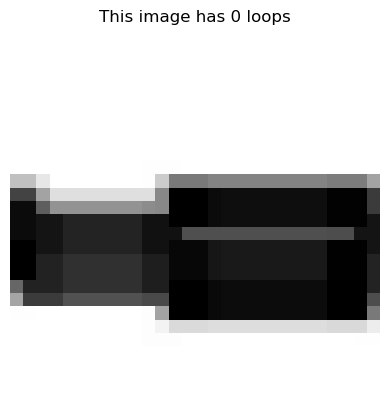

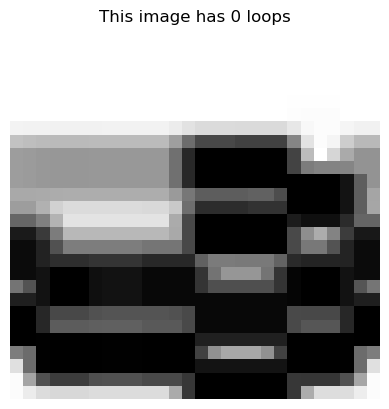

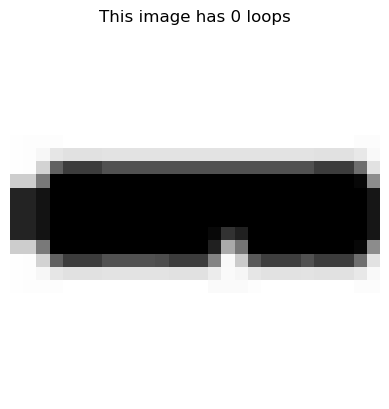

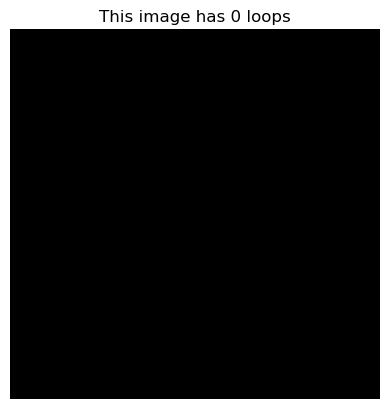

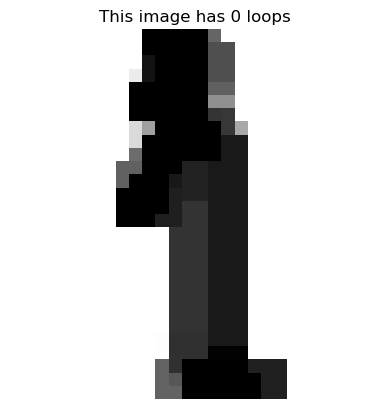

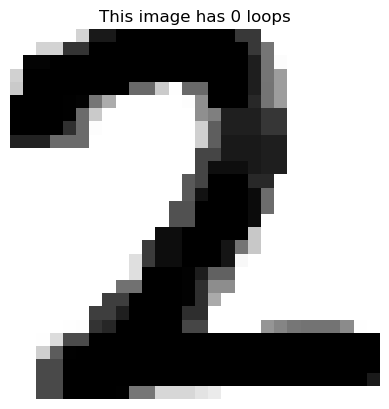

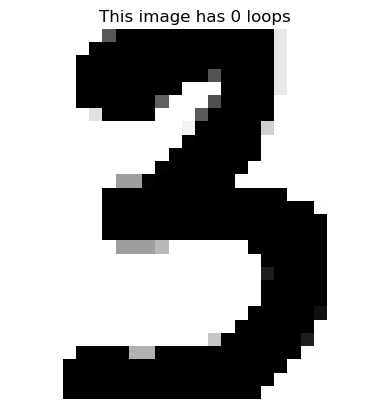

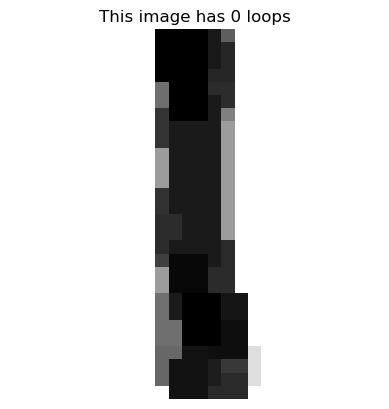

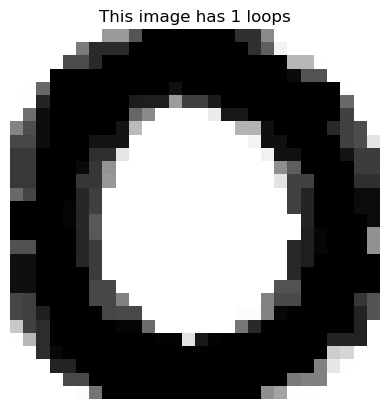

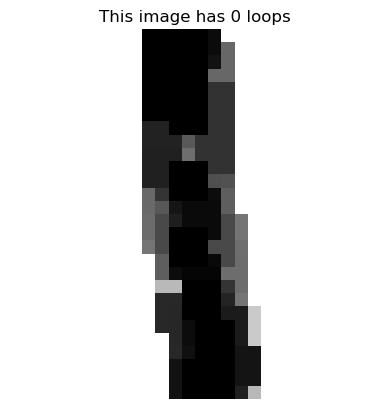

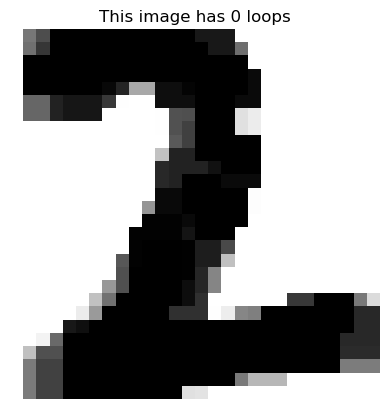

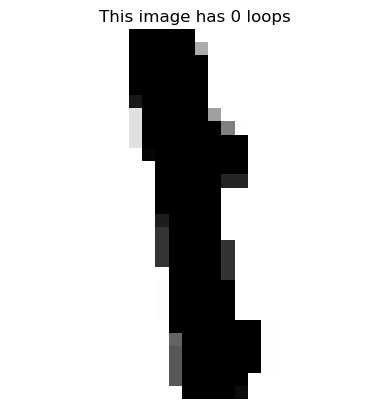

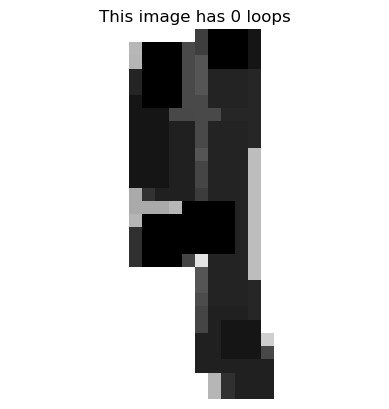

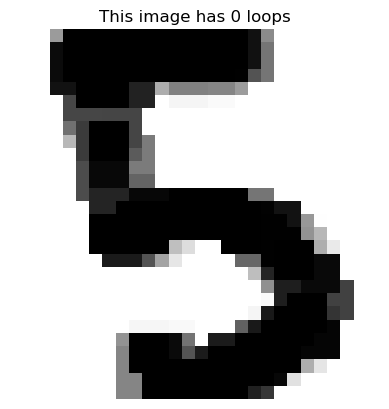

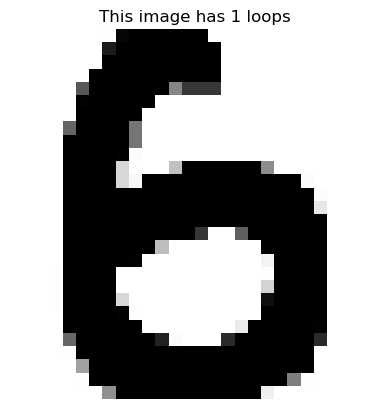

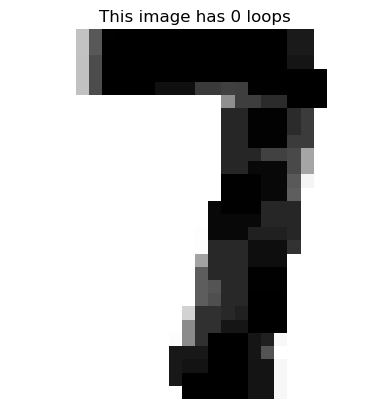

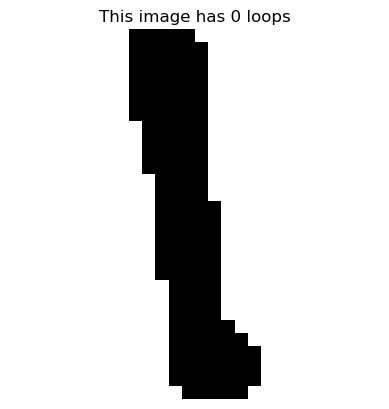

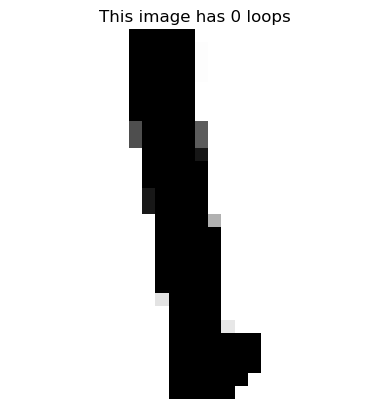

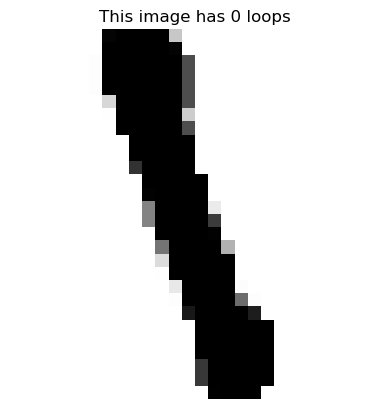

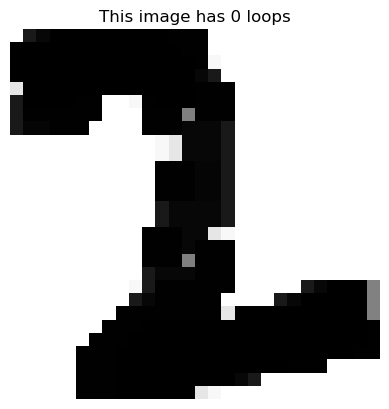

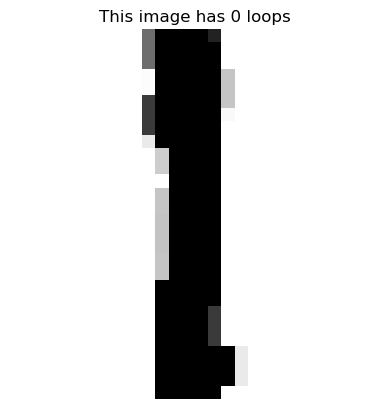

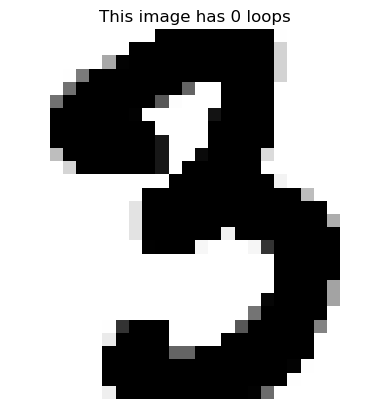

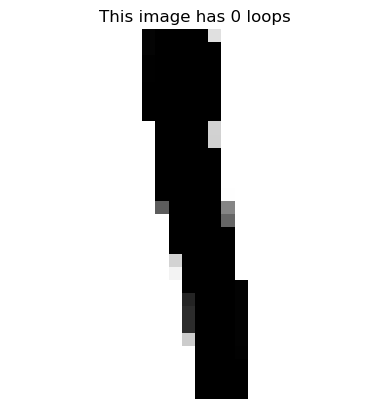

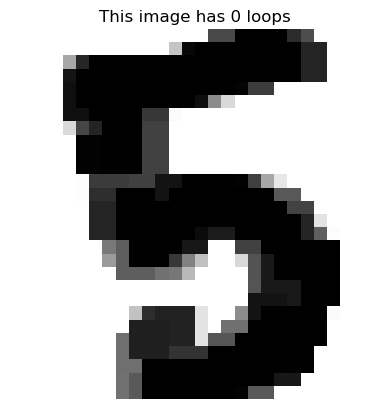

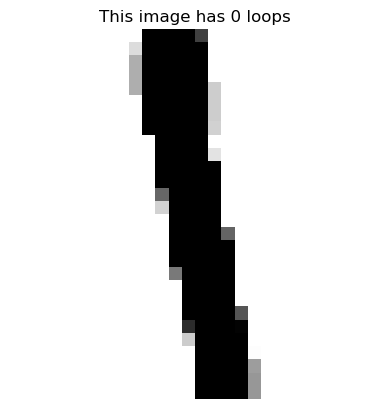

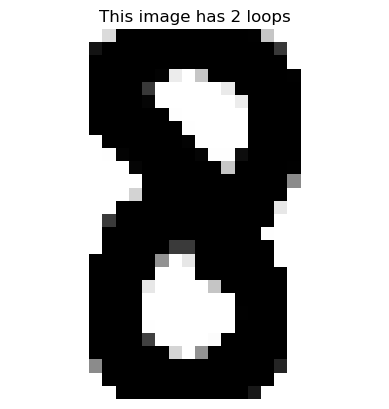

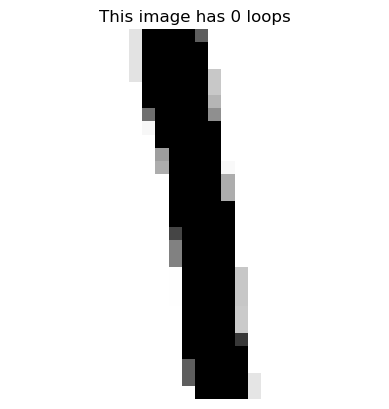

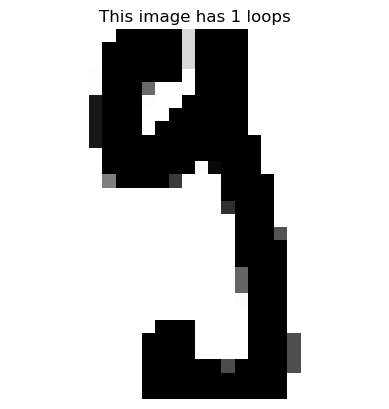

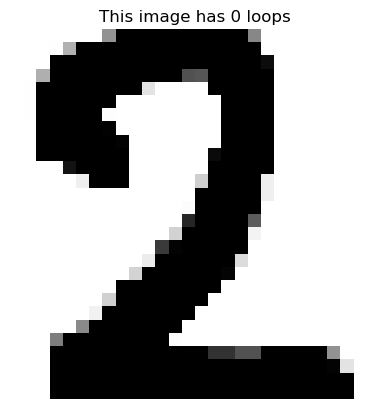

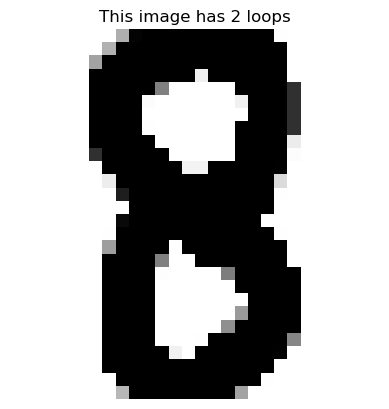

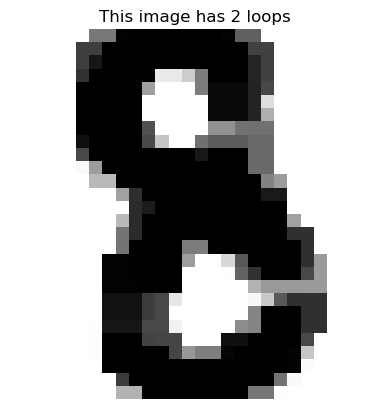

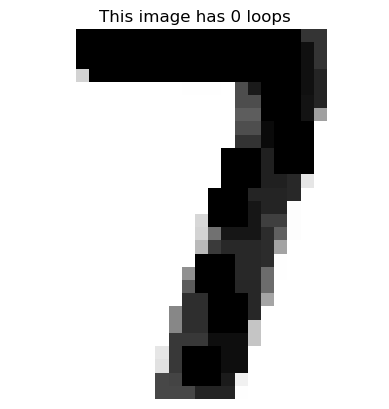

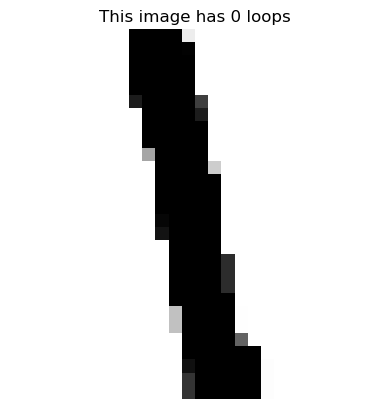

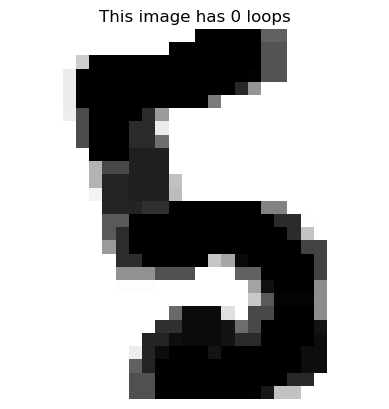

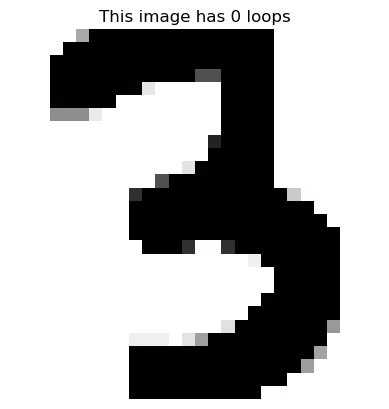

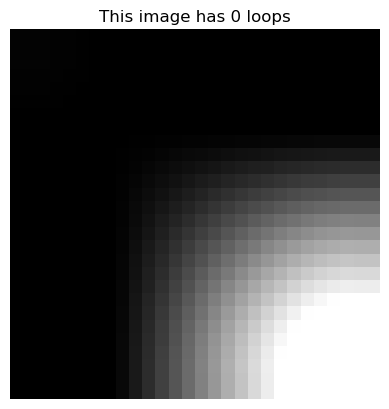

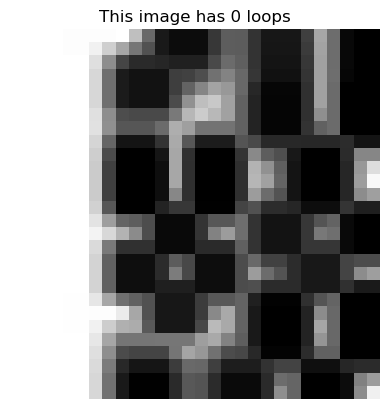

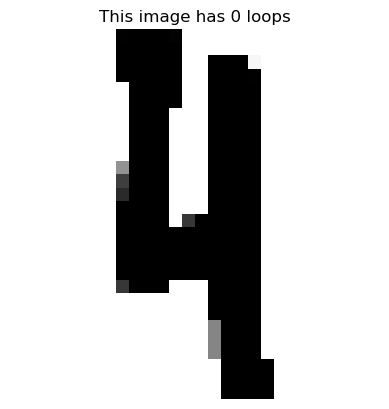

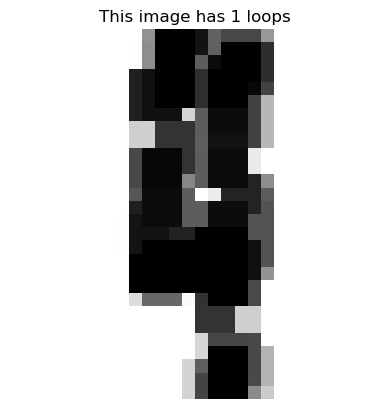

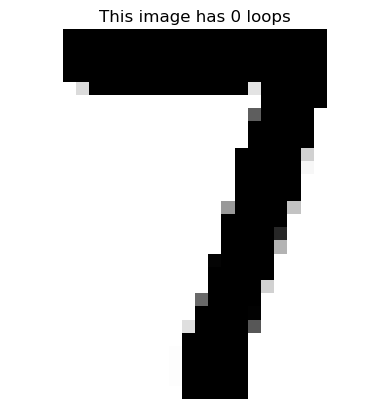

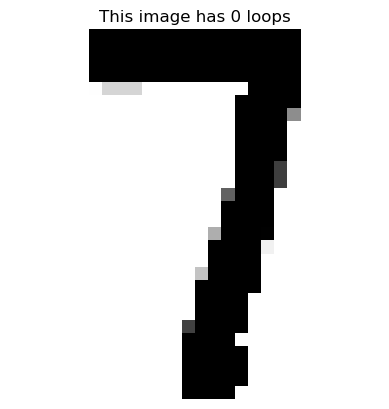

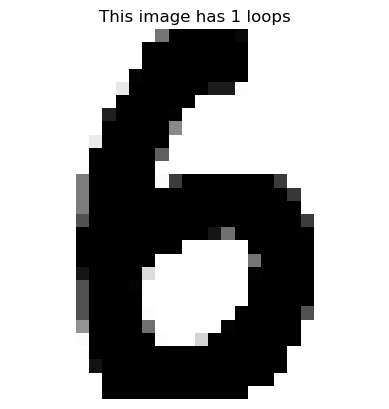

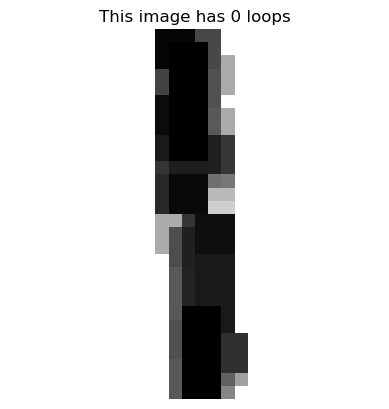

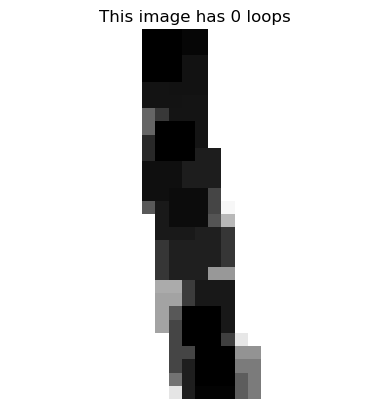

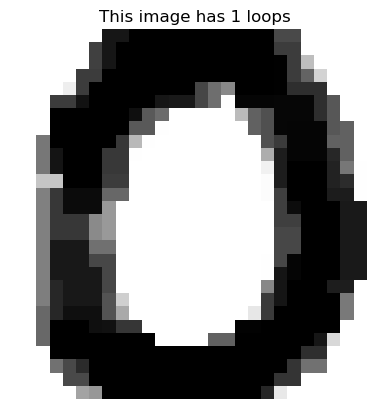

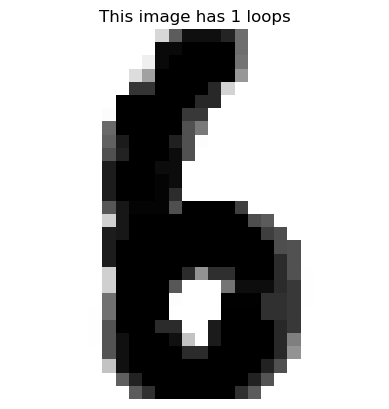

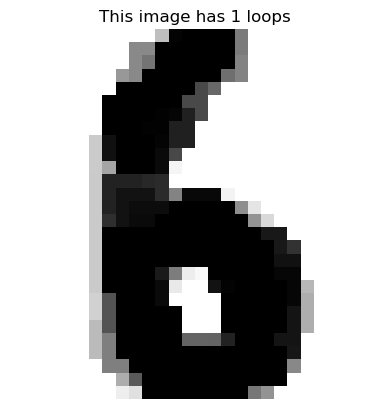

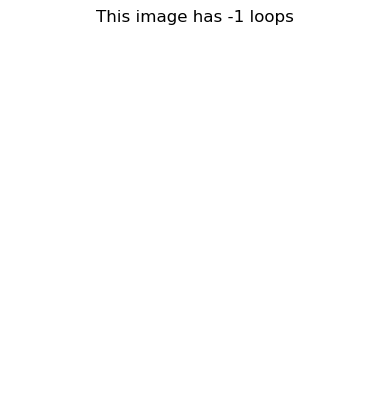

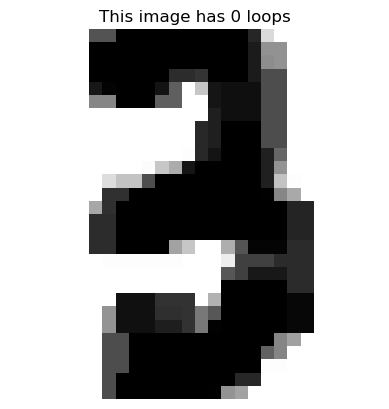

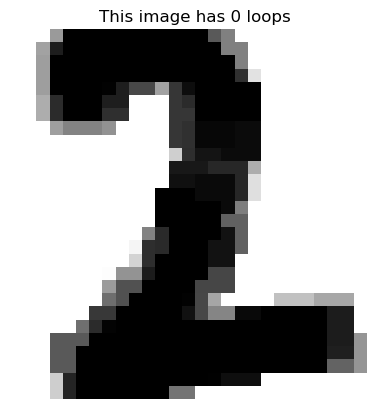

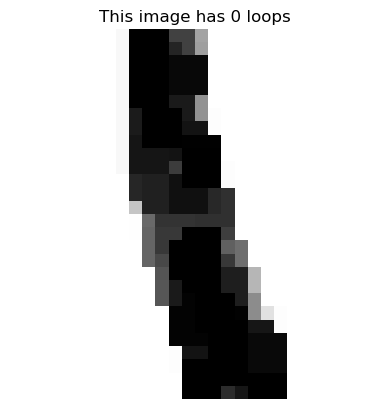

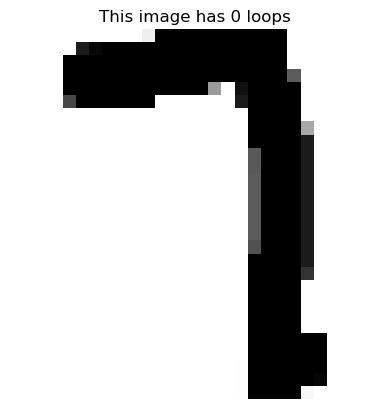

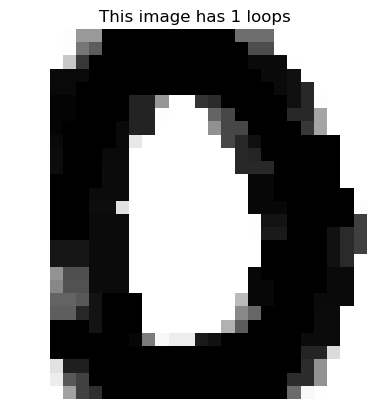

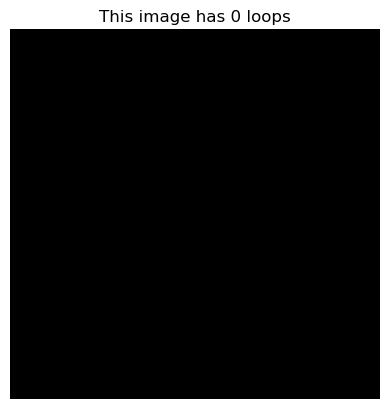

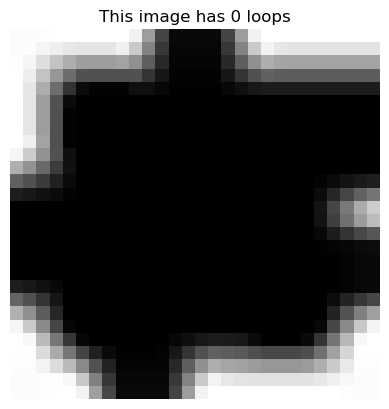

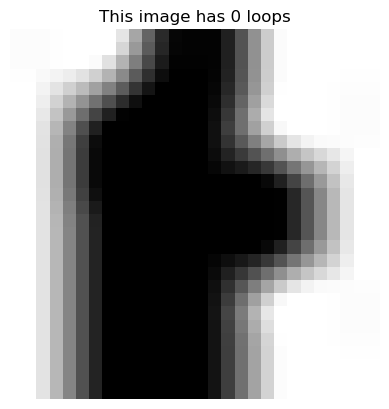

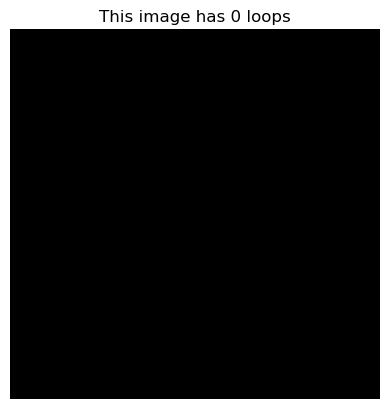

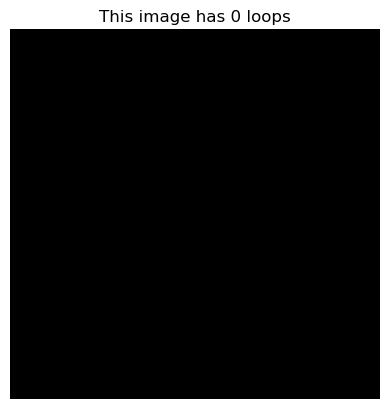

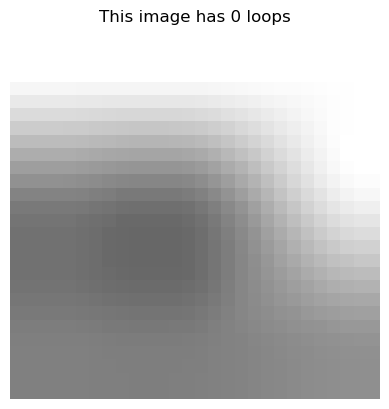

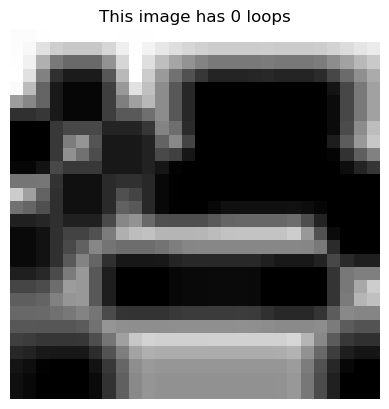

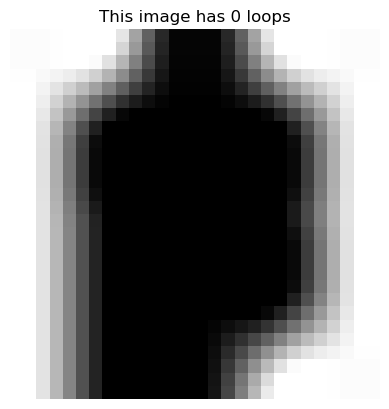

In [45]:
for i in range(len(numbers)):
    mat = numbers[i][:(28*28)].reshape(28,28)
    cnt_label = numbers[i][784]
    showPicture(mat, False, caption="This image has {} loops".format(cnt_label))